In [33]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import os
import pandas as pd
import numpy as np
import random
import joblib
import re
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,recall_score,classification_report,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier,VotingClassifier,RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

In [34]:
def load_reviews_from_folder(folder_path):

    reviews = []
    for filename in os.listdir(folder_path):
        
        file_path = os.path.join(folder_path, filename)
        
        if filename.endswith('.txt'):    
            with open(file_path, 'r', encoding='utf-8') as f:
                review = f.read().strip()

                if review:
                    reviews.append(review)
    return reviews

positive_folder = r'C:\Users\moham\Downloads\College\NLP\project\review_polarity\txt_sentoken\pos'  
negative_folder = r'C:\Users\moham\Downloads\College\NLP\project\review_polarity\txt_sentoken\neg' 

positive_reviews = load_reviews_from_folder(positive_folder)
negative_reviews = load_reviews_from_folder(negative_folder)

print(f"Loaded {len(positive_reviews)} positive reviews.")
print(f"Loaded {len(negative_reviews)} negative reviews.")

Loaded 1000 positive reviews.
Loaded 1000 negative reviews.


# Merge and Shuffle the Data

In [35]:
labeled_positive = [(review, 1) for review in positive_reviews]
labeled_negative = [(review, 0) for review in negative_reviews]

all_reviews = labeled_positive + labeled_negative
random.shuffle(all_reviews)

# PreProcessing

In [36]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer('english')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text, flag = 1, method=porter):
    
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    if flag == 1:
        tagged_tokens = pos_tag(tokens)
        processed = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    elif flag == 0:
        processed = [method.stem(word) for word in tokens]
    else:
        raise ValueError("Invalid method. Choose from: 'lemmatize', 'porter', 'lancaster', 'snowball'.")

    return ' '.join(processed)

cleaned_texts = [preprocess_text(text,flag=0,method=snowball) for text, label in all_reviews]
labels = [label for text, label in all_reviews]

new_df = pd.DataFrame({'Text': cleaned_texts, 'label': labels})
new_df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,label
0,end affair dark moodi romant period piec neil ...,1
1,thriller set modern day seattl mark marki mark...,1
2,stuck promis emblazon origin movi poster seque...,0
3,realm scienc fiction alway allegori polit mora...,0
4,earth harsh unconsol drama time india gain ind...,1


# EDA

# Word Count for Reviews

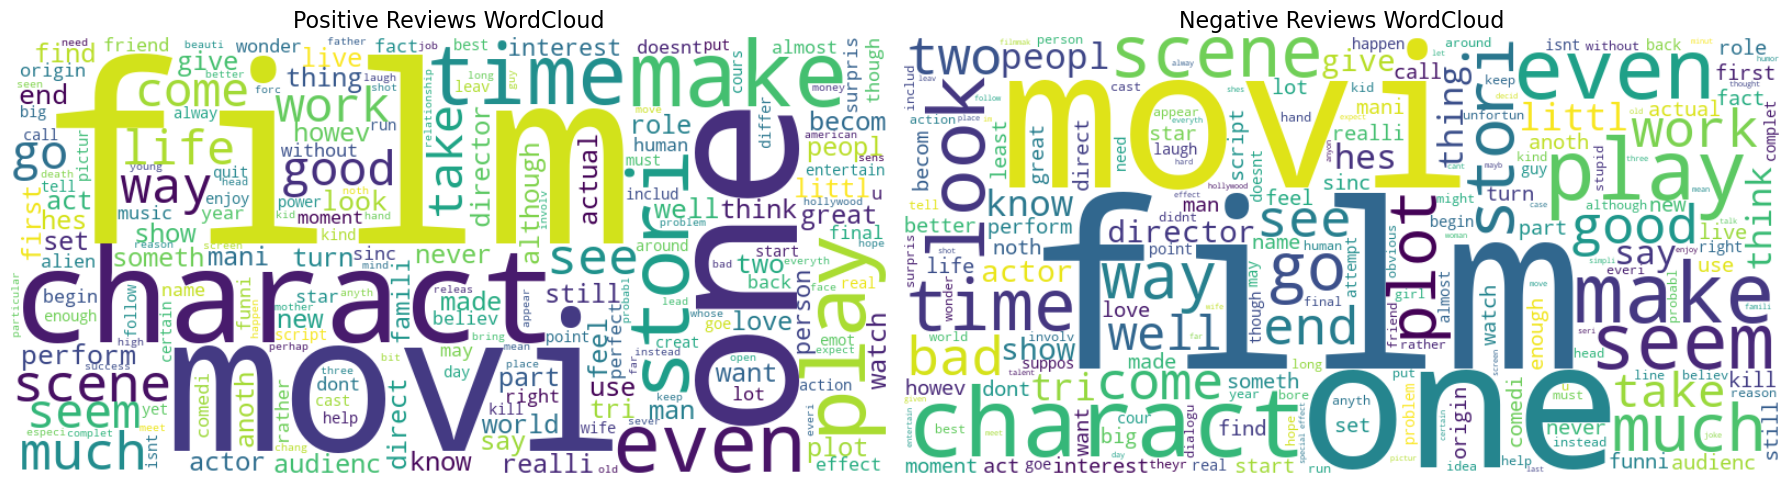

In [37]:
positive_reviews = ' '.join(new_df[new_df['label'] == 1]['Text'].tolist())
negative_reviews = ' '.join(new_df[new_df['label'] == 0]['Text'].tolist())

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Reviews WordCloud", fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Reviews WordCloud", fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

# Distibution of Classes

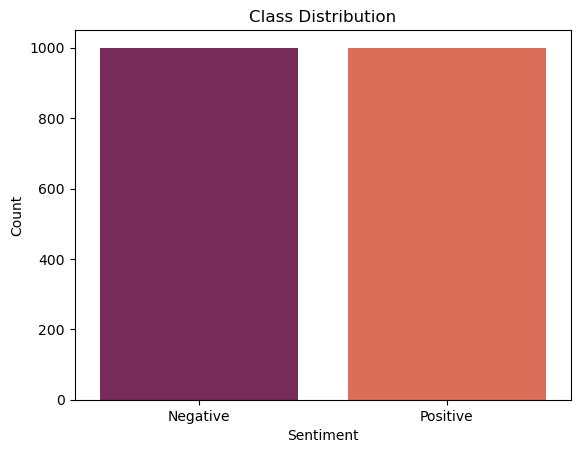

In [38]:
sns.countplot(x=labels,palette="rocket")
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Lenght Of Words

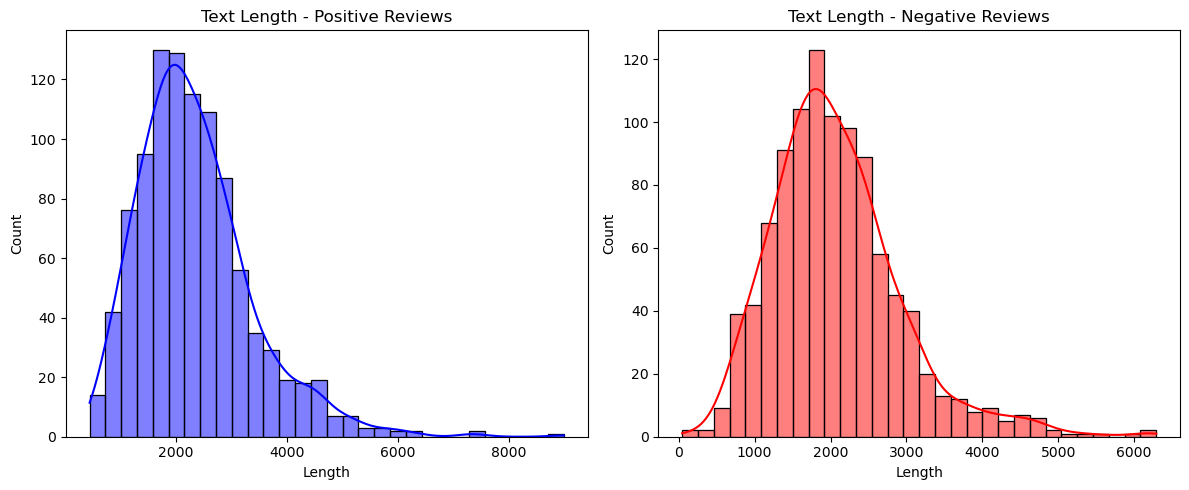

In [39]:
new_df['text_length'] = new_df['Text'].apply(len)

df_pos = new_df[new_df['label'] == 1]
df_neg = new_df[new_df['label'] == 0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_pos['text_length'], bins=30, kde=True, color='blue')
plt.title("Text Length - Positive Reviews")
plt.xlabel("Length")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(df_neg['text_length'], bins=30, kde=True, color='red')
plt.title("Text Length - Negative Reviews")
plt.xlabel("Length")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

new_df.drop("text_length",axis=1,inplace=True)

# Another Plot For Most Frequent Words in (Pos & Neg)

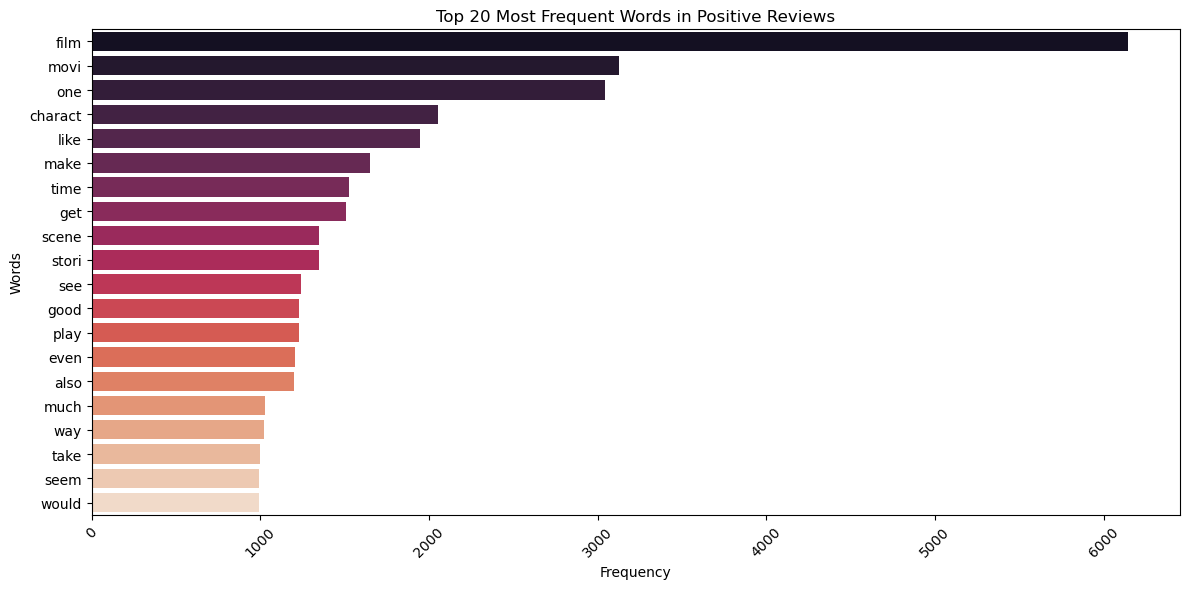

In [40]:
words = positive_reviews.split()
word_counts = Counter(words)

top_n = 20
common_words = word_counts.most_common(top_n)
df_common = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_common, y='word', x='count', palette='rocket')
plt.xticks(rotation=45)
plt.title(f"Top {top_n} Most Frequent Words in Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

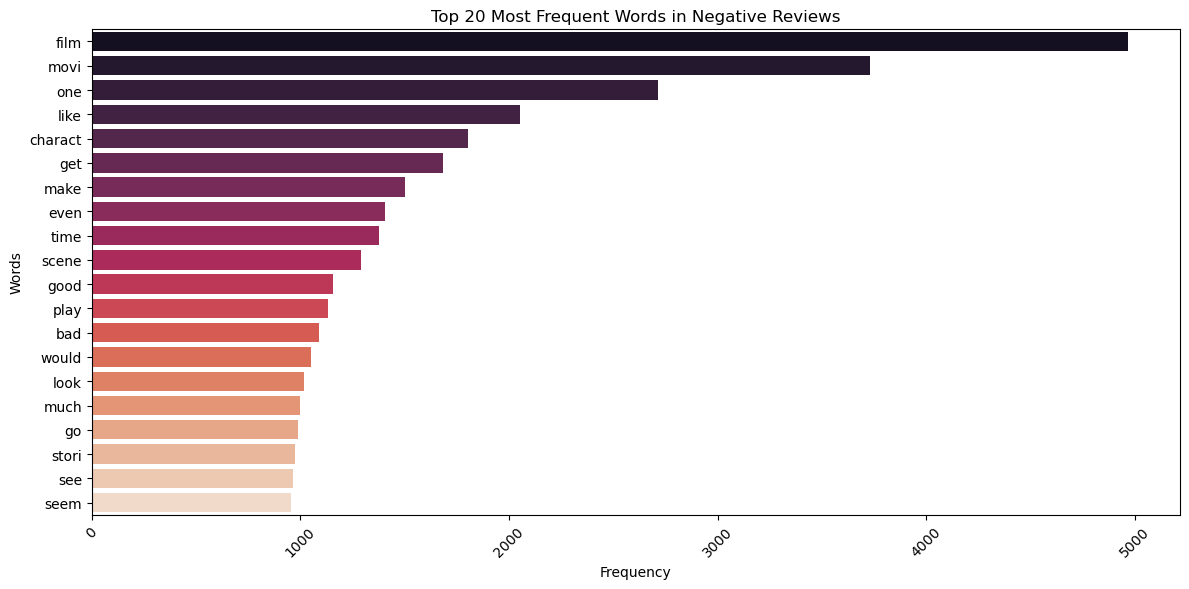

In [41]:
words_neg = negative_reviews.split()
word_counts = Counter(words_neg)

top_n = 20
common_words = word_counts.most_common(top_n)
df_common_neg = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_common_neg, y='word', x='count', palette='rocket')
plt.xticks(rotation=45)
plt.title(f"Top {top_n} Most Frequent Words in Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

# Feature Extraction

# BOW

In [42]:
X_train, X_test, y_train, y_test = train_test_split(new_df['Text'], new_df['label'], test_size=0.2, random_state=42)

bow_vectorizer = CountVectorizer()

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF (Unigrams)

In [43]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Word2Vec Embeddings

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
tokenized_train = [word_tokenize(text) for text in X_train]
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

def vectorize_text(text):
    words = word_tokenize(text)
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_w2v = np.array([vectorize_text(text) for text in X_train])
X_test_w2v = np.array([vectorize_text(text) for text in X_test])

# TF-IDF (N-grams: Unigrams + Bigrams)

In [ ]:
tfidf_ngram = TfidfVectorizer(ngram_range=(1, 2))

X_train_tfidf_unigram = tfidf_ngram.fit_transform(X_train)
X_test_tfidf_unigram = tfidf_ngram.transform(X_test)

# Model Training & Evaluation

# Logistic Regression

In [47]:
feature_sets = {
    'BoW': (X_train_bow, X_test_bow),
    'TF-IDF': (X_train_tfidf, X_test_tfidf),
    # 'Word2Vec': (X_train_w2v, X_test_w2v),
    # 'TF-IDF Unigram': (X_train_tfidf_unigram, X_test_tfidf_unigram)
}

results = []

for name, (X_train, X_test) in feature_sets.items():
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)

    y_pred_train = log_reg.predict(X_train)
    y_pred_test = log_reg.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    results.append({
        'Feature Set': name,
        'Train Accuracy': acc_train,
        'Test Accuracy': acc_test
    })

results_df = pd.DataFrame(results)
print(results_df)
print("###################################################################\n")
print(classification_report(y_test, y_pred_test))

  Feature Set  Train Accuracy  Test Accuracy
0         BoW        1.000000         0.8800
1      TF-IDF        0.970625         0.8475
###################################################################

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       194
           1       0.85      0.86      0.85       206

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



# Plots

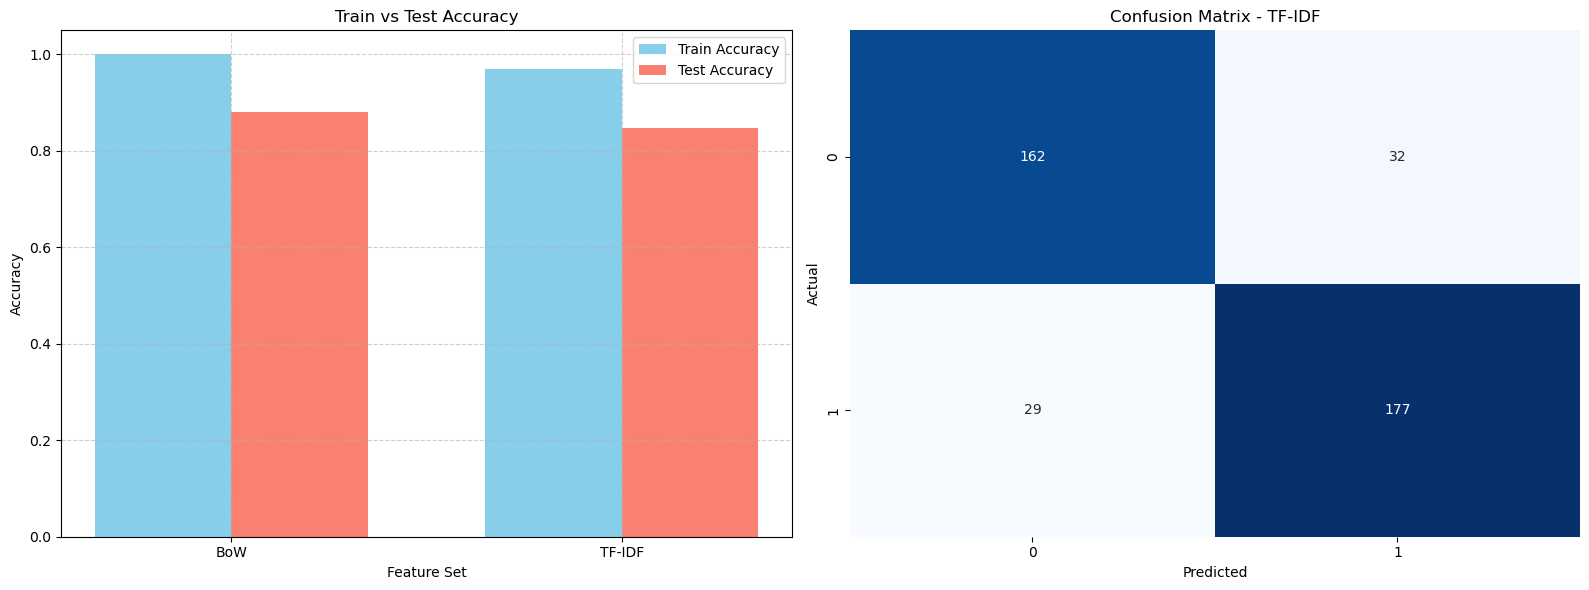

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.35
x = range(len(results_df))

axes[0].bar(x, results_df['Train Accuracy'], width=bar_width, label='Train Accuracy', color='skyblue')
axes[0].bar([i + bar_width for i in x], results_df['Test Accuracy'], width=bar_width, label='Test Accuracy', color='salmon')

axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(results_df['Feature Set'])
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)

axes[1].set_title(f'Confusion Matrix - {name}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# Random Forest

In [49]:
results = []

for name, (X_train, X_test) in feature_sets.items():
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    results.append({
        'Feature Set': name,
        'Train Accuracy': acc_train,
        'Test Accuracy': acc_test
    })

results_df = pd.DataFrame(results)
print(results_df)
print("###################################################################\n")
print(classification_report(y_test, y_pred_test))

  Feature Set  Train Accuracy  Test Accuracy
0         BoW             1.0         0.8325
1      TF-IDF             1.0         0.8150
###################################################################

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       194
           1       0.88      0.75      0.81       206

    accuracy                           0.81       400
   macro avg       0.82      0.82      0.81       400
weighted avg       0.82      0.81      0.81       400



Feature Set  Train Accuracy  Test Accuracy
0         BoW             1.0         0.8150
1      TF-IDF             1.0         0.8125

with lancaster stemmer

# Plots

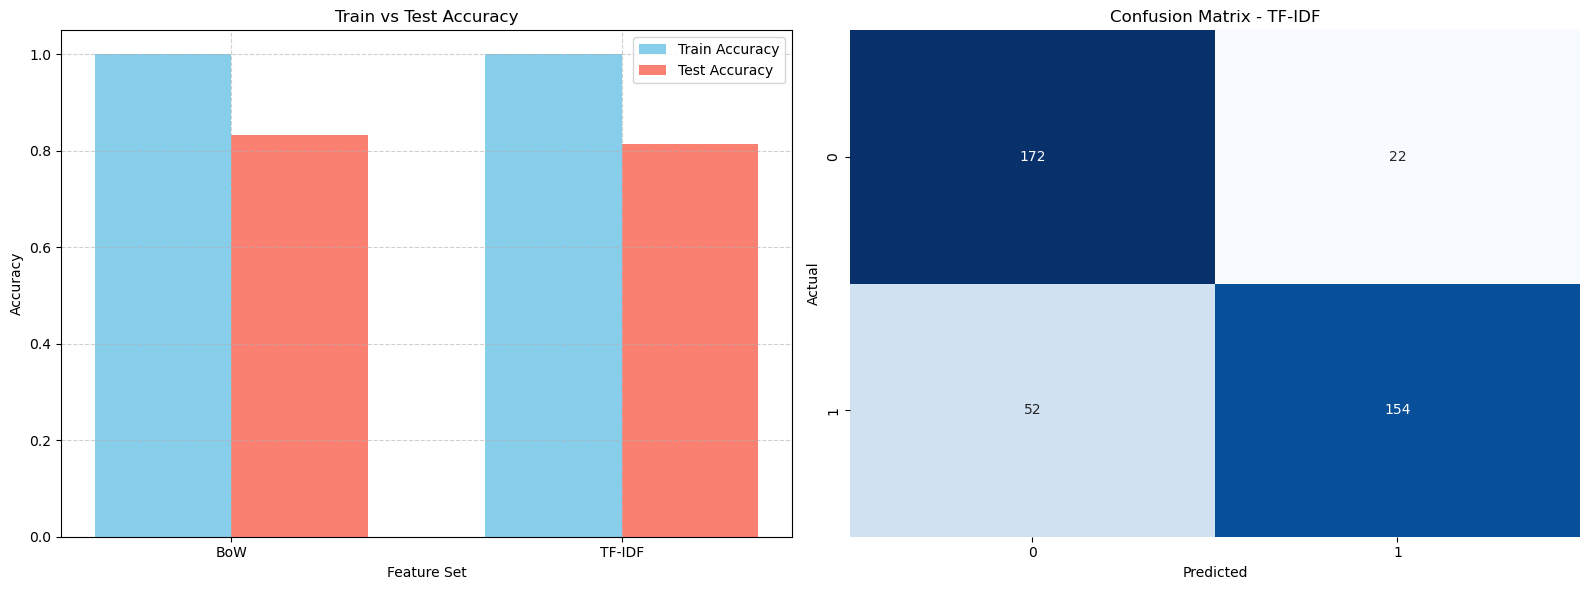

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.35
x = range(len(results_df))

axes[0].bar(x, results_df['Train Accuracy'], width=bar_width, label='Train Accuracy', color='skyblue')
axes[0].bar([i + bar_width for i in x], results_df['Test Accuracy'], width=bar_width, label='Test Accuracy', color='salmon')

axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(results_df['Feature Set'])
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)

axes[1].set_title(f'Confusion Matrix - {name}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# SVM

In [51]:
results = []

for name, (X_train, X_test) in feature_sets.items():
    svc = SVC()
    svc.fit(X_train, y_train)

    y_pred_train = svc.predict(X_train)
    y_pred_test = svc.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    results.append({
        'Feature Set': name,
        'Train Accuracy': acc_train,
        'Test Accuracy': acc_test
    })

results_df = pd.DataFrame(results)
print(results_df)
print("###################################################################\n")
print(classification_report(y_test, y_pred_test))

  Feature Set  Train Accuracy  Test Accuracy
0         BoW        0.977500         0.8225
1      TF-IDF        0.999375         0.8475
###################################################################

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       194
           1       0.85      0.86      0.85       206

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



# Plots

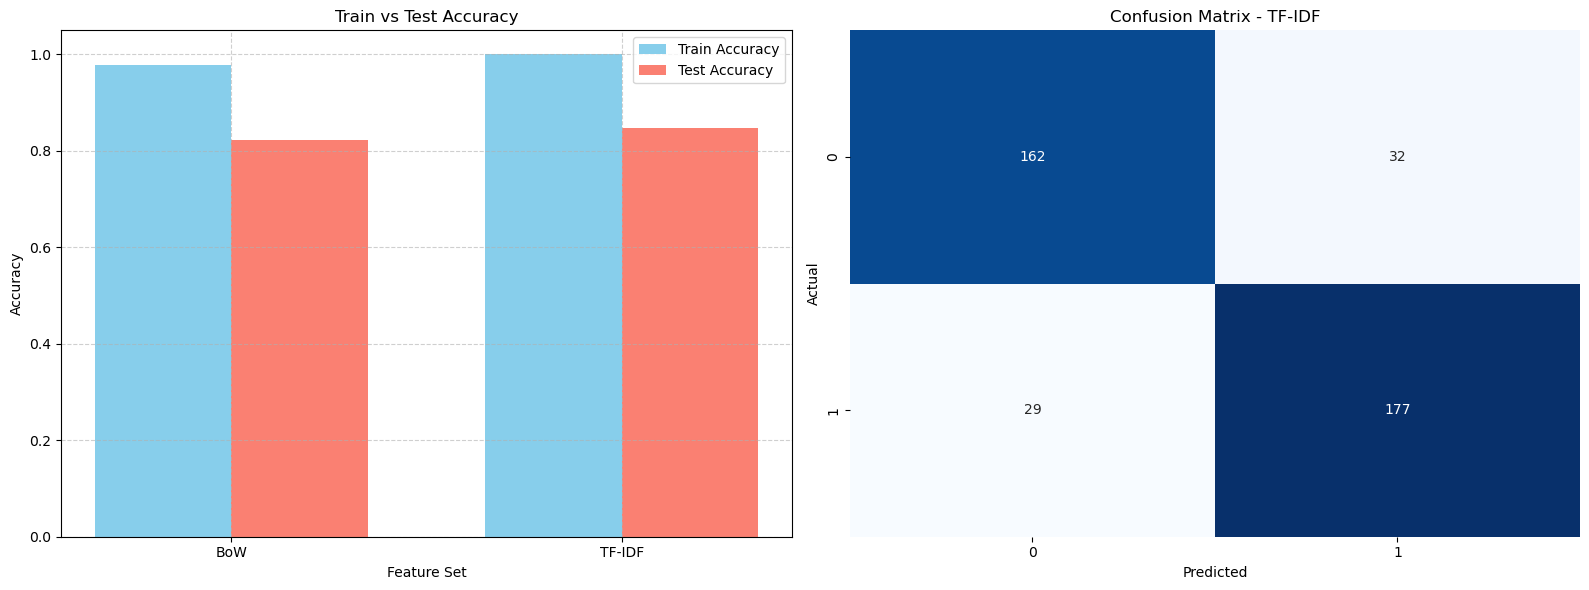

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.35
x = range(len(results_df))

axes[0].bar(x, results_df['Train Accuracy'], width=bar_width, label='Train Accuracy', color='skyblue')
axes[0].bar([i + bar_width for i in x], results_df['Test Accuracy'], width=bar_width, label='Test Accuracy', color='salmon')

axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(results_df['Feature Set'])
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)

axes[1].set_title(f'Confusion Matrix - {name}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# KNN

In [53]:
results = []

for name, (X_train, X_test) in feature_sets.items():
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    results.append({
        'Feature Set': name,
        'Train Accuracy': acc_train,
        'Test Accuracy': acc_test
    })

results_df = pd.DataFrame(results)
print(results_df)
print("###################################################################\n")
print(classification_report(y_test, y_pred_test))

  Feature Set  Train Accuracy  Test Accuracy
0         BoW         0.72625           0.60
1      TF-IDF         0.79000           0.67
###################################################################

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       194
           1       0.66      0.73      0.69       206

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



# Plots

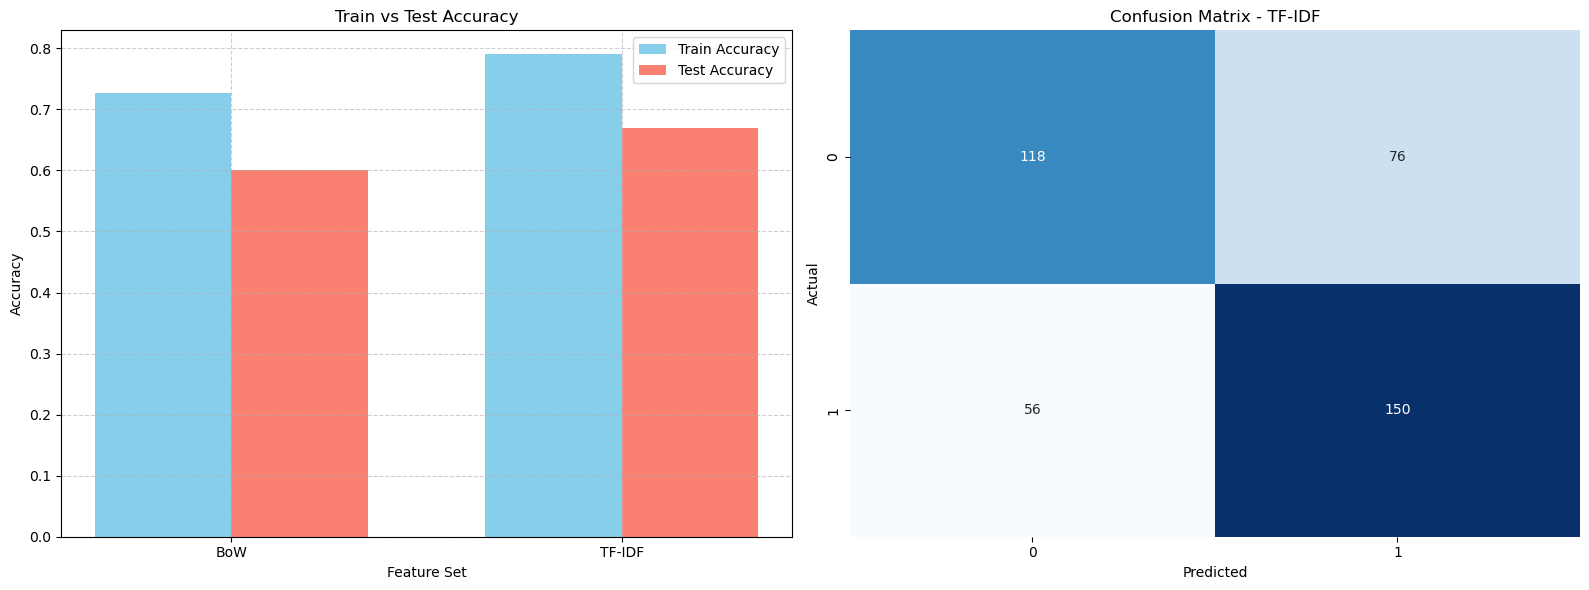

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.35
x = range(len(results_df))

axes[0].bar(x, results_df['Train Accuracy'], width=bar_width, label='Train Accuracy', color='skyblue')
axes[0].bar([i + bar_width for i in x], results_df['Test Accuracy'], width=bar_width, label='Test Accuracy', color='salmon')

axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(results_df['Feature Set'])
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)

axes[1].set_title(f'Confusion Matrix - {name}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Feature Set  Train Accuracy  Test Accuracy
0             BoW        0.698125         0.6375
1          TF-IDF        0.796250         0.6825
2  TF-IDF Unigram        0.795000         0.6500

# XGBOOST

In [55]:
results = []

for name, (X_train, X_test) in feature_sets.items():
    xgb1 = xgb.XGBClassifier()
    xgb1.fit(X_train, y_train)

    y_pred_train = xgb1.predict(X_train)
    y_pred_test = xgb1.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    results.append({
        'Feature Set': name,
        'Train Accuracy': acc_train,
        'Test Accuracy': acc_test
    })

results_df = pd.DataFrame(results)
print(results_df)
print("###################################################################\n")
print(classification_report(y_test, y_pred_test))

  Feature Set  Train Accuracy  Test Accuracy
0         BoW             1.0         0.8500
1      TF-IDF             1.0         0.8575
###################################################################

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       194
           1       0.90      0.82      0.85       206

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



# Plots

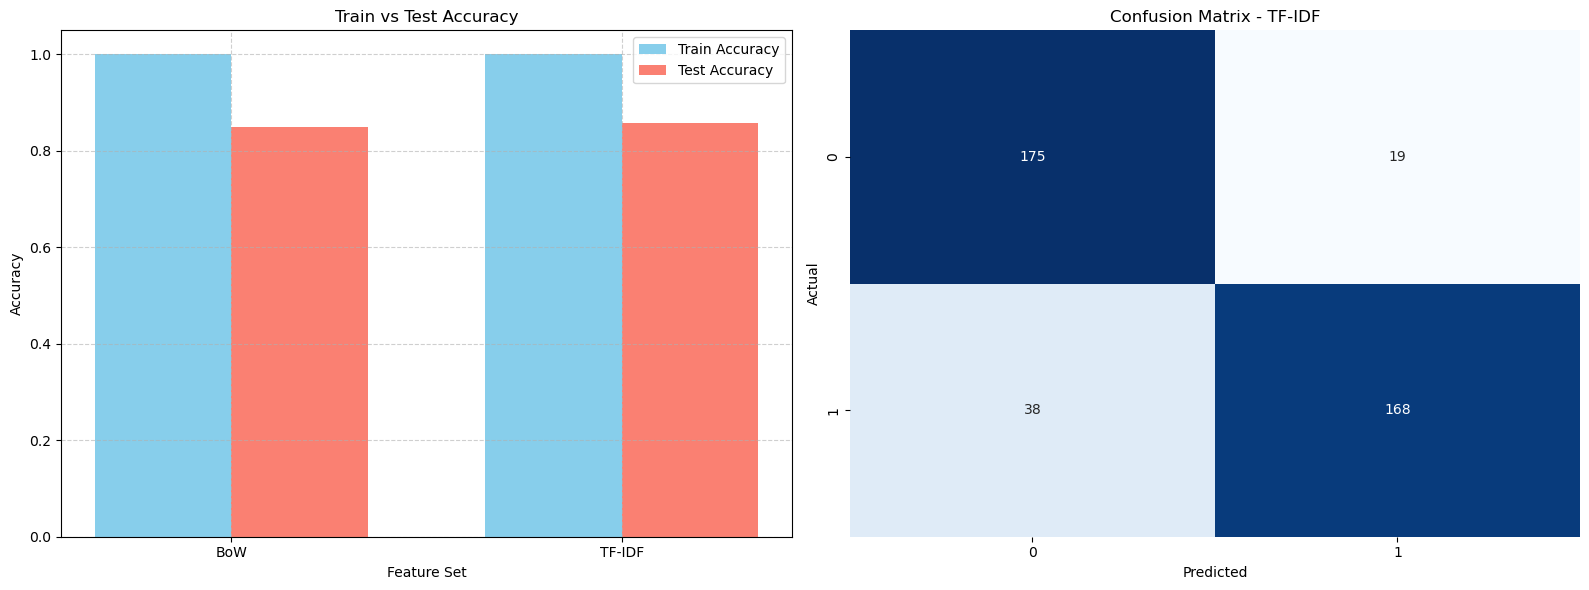

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.35
x = range(len(results_df))

axes[0].bar(x, results_df['Train Accuracy'], width=bar_width, label='Train Accuracy', color='skyblue')
axes[0].bar([i + bar_width for i in x], results_df['Test Accuracy'], width=bar_width, label='Test Accuracy', color='salmon')

axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(results_df['Feature Set'])
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)

axes[1].set_title(f'Confusion Matrix - {name}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Feature Set  Train Accuracy  Test Accuracy
0         BoW             1.0         0.8175
1      TF-IDF             1.0         0.8125

with lancaster stemmer

# LGBM

In [57]:
results = []

for name, (X_train, X_test) in feature_sets.items():
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    lgbm = lgb.LGBMClassifier()
    lgbm.fit(X_train, y_train)

    y_pred_train = lgbm.predict(X_train)
    y_pred_test = lgbm.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    results.append({
        'Feature Set': name,
        'Train Accuracy': acc_train,
        'Test Accuracy': acc_test
    })

results_df = pd.DataFrame(results)
print(results_df)
print("###################################################################\n")
print(classification_report(y_test, y_pred_test))

[LightGBM] [Info] Number of positive: 794, number of negative: 806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13487
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 3265
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496250 -> initscore=-0.015000
[LightGBM] [Info] Start training from score -0.015000
[LightGBM] [Info] Number of positive: 794, number of negative: 806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110376
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 3265
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496250 -> initscore=-0.015000
[Ligh

 Feature Set  Train Accuracy  Test Accuracy
0         BoW             1.0         0.8325
1      TF-IDF             1.0         0.8200

with lancaster stemmer

# Plots

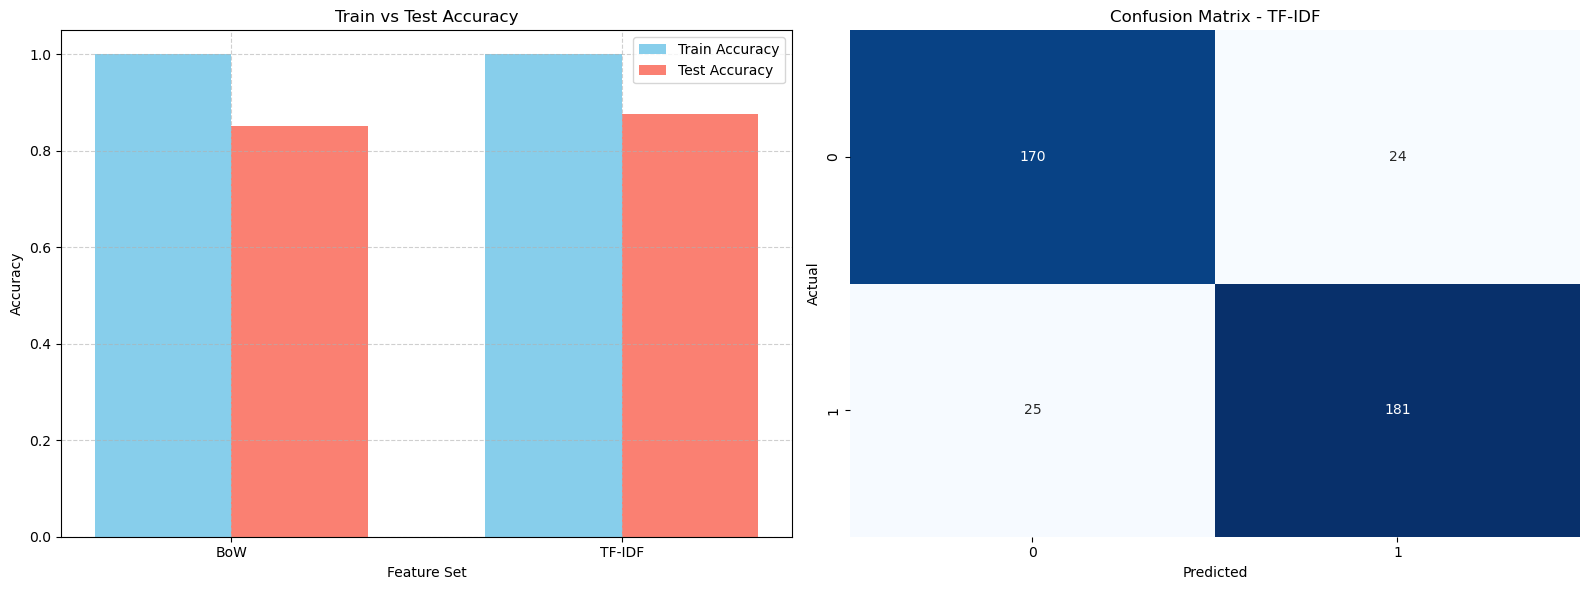

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.35
x = range(len(results_df))

axes[0].bar(x, results_df['Train Accuracy'], width=bar_width, label='Train Accuracy', color='skyblue')
axes[0].bar([i + bar_width for i in x], results_df['Test Accuracy'], width=bar_width, label='Test Accuracy', color='salmon')

axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(results_df['Feature Set'])
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)

axes[1].set_title(f'Confusion Matrix - {name}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Grid Search With Best Models

**1- For Logistic Regression**

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
}

log_reg = LogisticRegression()
grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

best_model = grid.best_estimator_

y_pred_train = best_model.predict(X_train_tfidf)
y_pred_test = best_model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Best Parameters:", grid.best_params_)
print(f"Train Accuracy of Best Model: {train_accuracy:.4f}")
print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

**2- SVM**

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],  
    'kernel': ['linear', 'rbf'],      
    'gamma': ['scale', 'auto'],
    'max_iter': [ 500 , 1000]
}

svm = SVC()

grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

best_model = grid.best_estimator_

y_pred_train = best_model.predict(X_train_tfidf)
y_pred_test = best_model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Best Parameters:", grid.best_params_)
print(f"Train Accuracy of Best Model: {train_accuracy:.4f}")
print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")


# PCA With Best Parameters

**1- Logisitc**

In [61]:
svd = TruncatedSVD(n_components=400)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

log_reg_best_params = {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
log_reg = LogisticRegression(**log_reg_best_params)
log_reg.fit(X_train_svd, y_train)

y_pred_train = log_reg.predict(X_train_svd)
y_pred_test = log_reg.predict(X_test_svd)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy : {train_accuracy:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")


Train Accuracy : 0.8981
Test Accuracy : 0.8250


**2-SVM**

In [62]:
svd = TruncatedSVD(n_components=350)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

svm_best_params = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 500}

svm= SVC(**svm_best_params)
svm.fit(X_train_svd, y_train)

y_pred_train = svm.predict(X_train_svd)
y_pred_test = svm.predict(X_test_svd)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy : {train_accuracy:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")


Train Accuracy : 0.9513
Test Accuracy : 0.8450


# Training Best model 

In [ ]:
svm_best_params = {'C': 1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 1000, "probability":True}

svm= SVC(**svm_best_params)
svm.fit(X_train_tfidf, y_train)

y_pred_train = svm.predict(X_train_tfidf)
y_pred_test = svm.predict(X_test_tfidf)-

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy : {train_accuracy:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
print("###################################################################\n")
print(classification_report(y_test, y_pred_test))

Train Accuracy : 0.9900
Test Accuracy : 0.8725
###################################################################

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       194
           1       0.85      0.91      0.88       206

    accuracy                           0.87       400
   macro avg       0.88      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



# Plots

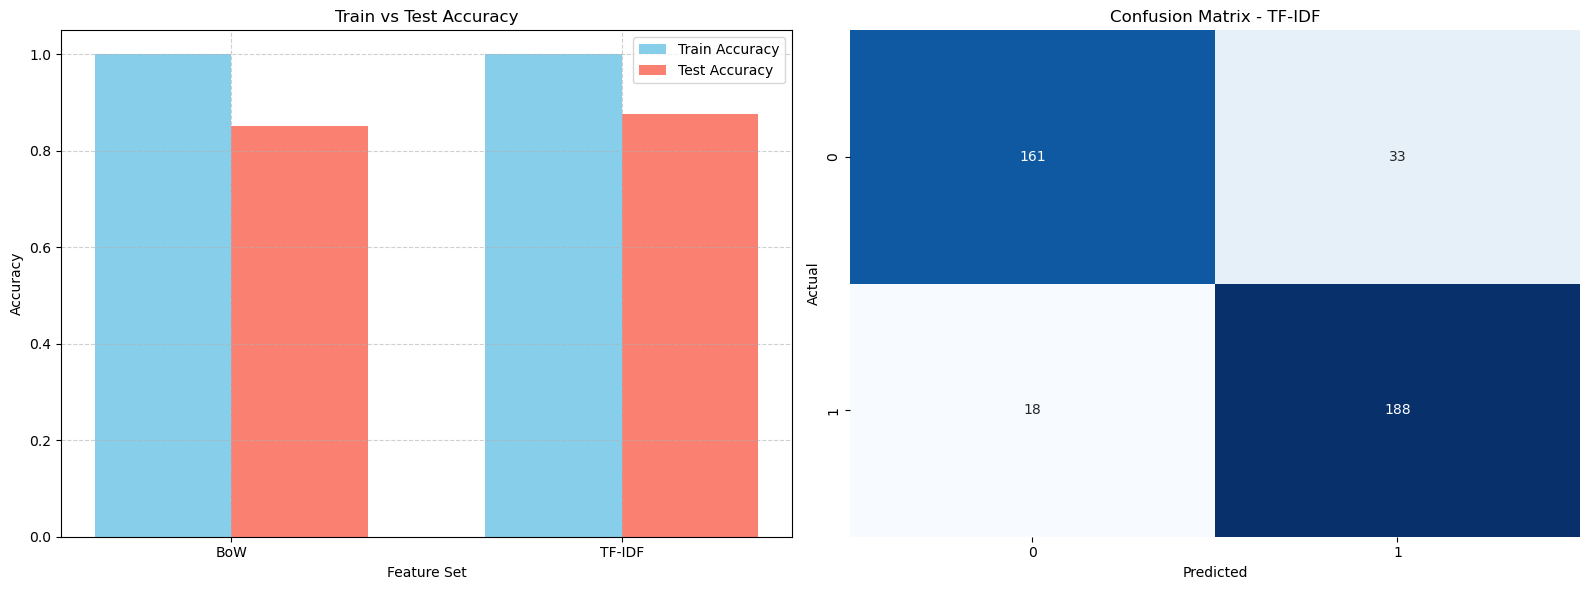

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.35
x = range(len(results_df))

axes[0].bar(x, results_df['Train Accuracy'], width=bar_width, label='Train Accuracy', color='skyblue')
axes[0].bar([i + bar_width for i in x], results_df['Test Accuracy'], width=bar_width, label='Test Accuracy', color='salmon')

axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(results_df['Feature Set'])
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)

axes[1].set_title(f'Confusion Matrix - {name}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC_AUC

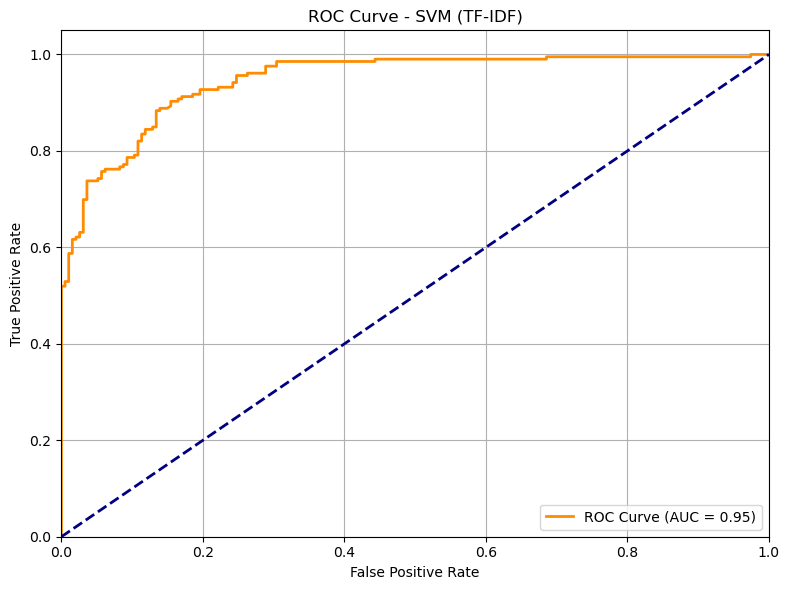

In [65]:
y_probs = svm.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (TF-IDF)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')